In [25]:
import pickle
import numpy as np
import pandas as pd

import torch
import json
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from embedding import BertHuggingface
from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias
from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline

## TODO
- (x) save results
- save embeddings per dataset + model name
- optimize cosine scores (apply row/col wise to numpy array of embeddings? instead of list comprehension)
- (x) configs for everything (-> set up separate experiment with CLFHead)
- (yes) are splits reproucible with the same random_state?
- roc AUC
- jigsaw dataset
- adaptions for jigsaw dataset -> or other file?
- (get llama models working)


In [26]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
with open('configs/bios_exp.json', 'r') as f:
    exp_config = json.load(f)
    
with open(exp_config['batch_size_lookup'], 'r') as f:
    batch_size_lookup = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

cosine_scores = {'SAME': SAME, 'WEAT': WEAT, 'gWEAT': GeneralizedWEAT, 'DirectBias': DirectBias, 'MAC': MAC}
optimizer = {'RMSprop': torch.optim.RMSprop, 'Adam': torch.optim.Adam}
criterions = {'BCEWithLogitsLosss': torch.nn.BCEWithLogitsLoss, 'MultiLabelSoftMarginLoss': torch.nn.MultiLabelSoftMarginLoss}

bios_merged_file = '../MeasuringFairnessWithBiasedData/data/BIOS_REVIEWED.pkl'
titles = ['architect', 'psychologist', 'professor', 'photographer', 'journalist', 'attorney', 'teacher', 'dentist', '*software architect', '*writer', 'surgeon', 
                       'physician', 'nurse', '*researcher']
n_classes = len(titles)

In [83]:
bios_dataset = BiosDataset(n_folds=exp_config['n_fold'], sel_labels=exp_config['bios_classes'], bios_file=exp_config['bios_file'])


In [85]:
bios_dataset.set_data_split(0)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,65,75,60,251,220,171,101,22,31,83,193,140,10,26
female,20,126,34,130,149,107,160,15,3,97,16,81,121,14


In [86]:
bios_dataset.set_data_split(1)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,55,78,56,241,186,192,106,22,38,84,193,162,10,37
female,18,112,43,122,162,102,151,11,6,91,33,90,124,20


In [87]:
bios_dataset.set_data_split(2)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,65,77,52,241,214,166,117,23,28,106,190,166,4,41
female,18,103,43,111,200,103,148,10,2,99,25,85,110,12


In [88]:
bios_dataset.set_data_split(3)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,54,77,48,218,168,197,96,15,40,92,196,165,15,38
female,20,132,53,115,181,116,147,14,1,90,21,93,120,17


In [89]:
bios_dataset.set_data_split(4)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,41,90,55,254,192,168,115,22,34,74,187,136,10,36
female,18,122,39,117,182,116,163,11,5,91,18,85,127,20


In [ ]:
bios_dataset2 = BiosDataset(n_folds=exp_config['n_fold'], sel_labels=titles, bios_file=bios_merged_file)
bios_dataset2.set_data_split(0)

In [ ]:
ids = [sample['id'] for sample in bios_dataset.train_data]
ids2 = [sample['id'] for sample in bios_dataset2.train_data]
ids == ids2

In [ ]:
lm = BertHuggingface(model_name='bert-base-uncased', batch_size=16, num_labels=len(titles))

In [9]:
bios_emb_all = lm.embed([sample['text'] for sample in bios_dataset.sel_data])

In [11]:
train_ids = [sample['id'] for sample in bios_dataset.train_data]
emb = [bios_emb_all[i] for i in train_ids]
X = [sample['text'] for sample in bios_dataset.train_data]
y = [sample['label'] for sample in bios_dataset.train_data]
groups = [sample['group'] for sample in bios_dataset.train_data]

lrs = [1e-03]
optimizers = ['Adam', 'RMSprop']
losses = ['BCEWithLogitsLoss']#, 'MultiLabelSoftMarginLoss']
epochs = [2, 5, 10, 20]
batch_sizes = [8]#, 16, 32, 64]

In [ ]:
for ep in epochs:
    for optim in optimizers:
        for loss in losses:
            for lr in lrs:
                for bs in batch_sizes:
                    params = {'optimizer': optim, 'criterion': loss, 'lr': lr, 'batch_size': bs, 'epochs': ep}
                    print(params)
                    head = CLFHead(input_size=lm.model.config.hidden_size, output_size=n_classes, hidden_size=lm.model.config.hidden_size)
                    pipeline = DebiasPipeline(params, head, debias=False)

                    # fit the whole pipeline
                    pipeline.fit(emb, y, epochs=params['epochs'], optimize_theta=True, group_label=groups)

In [ ]:
for ep in epochs:
    for optim in optimizers:
        for loss in losses:
            for lr in lrs:
                for bs in batch_sizes:
                    params = {'optimizer': optim, 'criterion': loss, 'lr': lr, 'batch_size': bs, 'epochs': ep}
                    print(params)
                    head = SimpleCLFHead(input_size=lm.model.config.hidden_size, output_size=n_classes)
                    pipeline = DebiasPipeline(params, head, debias=False)

                    # fit the whole pipeline
                    pipeline.fit(emb, y, epochs=params['epochs'], optimize_theta=True, group_label=groups)

# Test balancing data + ROC AUC score

In [3]:
exp_parameters = []
for bt in exp_config['bias_types']:
            for embedder in exp_config['embedders']:
                for head in exp_config['clf_heads']:
                    for optim in exp_config['clf_optimizer']:
                        for crit in exp_config['clf_criterion']:
                            for lr in exp_config['lr']:
                                # one without debias anyway
                                params = {key: exp_config[key] for key in ['bias_scores', 'n_fold', 'batch_size', 'epochs']}
                                params.update({'bias_type': bt, 'embedder': embedder, 'head': head, 
                                               'optimizer': optim, 'criterion': crit, 'lr': lr, 'debias': False})
                                exp_parameters.append(params)
                                if exp_config['debias']:
                                    for k in exp_config['debias_k']:
                                        params = {key: exp_config[key] for key in ['bias_scores', 'debias', 'n_fold', 'batch_size', 'epochs']}
                                        params.update({'bias_type': bt, 'embedder': embedder, 'head': head, 
                                                       'optimizer': optim, 'criterion': crit, 'lr': lr, 'debias_k': k})
                                        exp_parameters.append(params)  
                                        
params = exp_parameters[0]

In [4]:
bios_merged_file = exp_config['bios_file']
titles = exp_config['bios_classes']
n_classes = len(titles)
bios_dataset = BiosDataset(n_folds=exp_config['n_fold'], sel_labels=titles, bios_file=bios_merged_file)
print("loaded BIOS dataset with", len(bios_dataset.sel_data), "samples")
n_groups = len(bios_dataset.sel_groups)
mean_n_samples = len(bios_dataset.sel_data)/(n_classes*n_groups) # per class

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.sel_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
print("class/gender distribution:")
df

loaded BIOS dataset with 10887 samples
class/gender distribution:


,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,280,397,271,1205,980,894,535,104,171,439,959,769,49,178
female,94,595,212,595,874,544,769,61,17,468,113,434,602,83


In [5]:
fold_id = 0
bios_dataset.set_data_split(fold_id)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.train_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)

class_gender_weights = {g: {lbl: mean_n_samples/df.loc[g,lbl] for lbl in bios_dataset.labels} for g in bios_dataset.sel_groups}
print("class/group weights on training split:")
class_gender_weights

class/group weights on training split:


{'male': {'architect': 1.8084717607973422,
  'psychologist': 1.207519964507542,
  'professor': 1.842755585646581,
  'photographer': 0.4075696316262354,
  'journalist': 0.5116071428571428,
  'attorney': 0.5377889745109662,
  'teacher': 0.8959019091507571,
  'dentist': 4.741724738675958,
  '*software architect': 2.7772959183673467,
  '*writer': 1.0921950240770466,
  'surgeon': 0.5075997762029093,
  'physician': 0.618158074040427,
  'nurse': 9.969780219780219,
  '*researcher': 2.558035714285714},
 'female': {'architect': 5.254343629343629,
  'psychologist': 0.8290435577215961,
  'professor': 2.184390048154093,
  'photographer': 0.8361751152073732,
  'journalist': 0.5363054187192118,
  'attorney': 0.889751552795031,
  'teacher': 0.6384588318085854,
  'dentist': 8.452639751552795,
  '*software architect': 27.772959183673468,
  '*writer': 1.0480361956103195,
  'surgeon': 4.008468335787923,
  'physician': 1.1014771347632537,
  'nurse': 0.8083605583605583,
  '*researcher': 5.635093167701863}}

In [6]:
model_name = params['embedder']
if not model_name in batch_size_lookup.keys():
    print("batch size for model", model_name, "not specified, use 1")
    batch_size = 1
else:
    batch_size = batch_size_lookup[model_name]

lm = BertHuggingface(model_name=model_name, batch_size=batch_size, num_labels=len(titles))
emb_size = lm.model.config.hidden_size

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


In [7]:
bios_emb_all = lm.embed([sample['text'] for sample in bios_dataset.sel_data])

In [8]:
train_ids = [sample['id'] for sample in bios_dataset.train_data]
emb = np.asarray([bios_emb_all[i] for i in train_ids])
y = np.asarray([sample['label'] for sample in bios_dataset.train_data])
groups = [sample['group'] for sample in bios_dataset.train_data]

eval_ids = [sample['id'] for sample in bios_dataset.eval_data]
emb_eval = np.asarray([bios_emb_all[i] for i in eval_ids])
y_eval = [sample['label'] for sample in bios_dataset.eval_data]


In [9]:
# fit with weights
sample_weights = []
for sample in bios_dataset.train_data:
    labels = [bios_dataset.labels[i] for i in range(len(sample['label'])) if sample['label'][i] == 1]
    group = bios_dataset.sel_groups[sample['group']]
    weights = [class_gender_weights[group][lbl] for lbl in labels]
    sample_weights.append(np.max(weights))

# fit the whole pipeline
head = SimpleCLFHead(input_size=lm.model.config.hidden_size, output_size=n_classes)
pipeline = DebiasPipeline(params, head, debias=params['debias'])
pipeline.fit(emb, y, epochs=params['epochs'], optimize_theta=True, group_label=groups, weights=sample_weights)

eval_ids = [sample['id'] for sample in bios_dataset.eval_data]
emb_eval = np.asarray([bios_emb_all[i] for i in eval_ids])
y_eval = [sample['label'] for sample in bios_dataset.eval_data]
y_pred = pipeline.predict(emb_eval)
print("accuracy: ", accuracy_score(y_eval, y_pred))

print("ROC AUC per class:")
for i in range(n_classes):
    auc = roc_auc_score(np.asarray(y_eval)[:,i], y_pred[:,i])
    print(bios_dataset.labels[i], auc)
    
bios_dataset.group_bias(pipeline.predict, emb_eval)
print("GAPs:", bios_dataset.bias_score)

fit clf head...


Epoch 4: 100%|████████████████████████████████████████| 980/980 [00:04<00:00, 196.50it/s, loss=0.513]


optimize classification threshold...


100%|████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 3471.13it/s]


use theta=0.39999999999999997 which achieved accurcay: 0.6819747416762342


100%|████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 3351.58it/s]


accuracy:  0.6937557392102847
ROC AUC per class:
architect 0.8576290716955679
psychologist 0.9041250500154765
professor 0.5
photographer 0.9454427545471674
journalist 0.9056007226738936
attorney 0.9454297614539946
teacher 0.804273919378339
dentist 0.5
*software architect 0.952850636523266
*writer 0.6212712712712712
surgeon 0.9230707545908957
physician 0.8211189904207428
nurse 0.8241533877541888
*researcher 0.5


100%|████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 3944.62it/s]

GAPs: [0.08846153846153848, 0.030476190476190435, 0.0, 0.07073245479619972, 0.08316046369737651, 0.10974476690167789, -0.10699257425742581, 0.0, 0.6344086021505377, -0.07179232393491489, 0.20369170984455953, 0.1463844797178131, -0.4024793388429752, 0.0]


In [10]:
# fit without weights
head2 = SimpleCLFHead(input_size=lm.model.config.hidden_size, output_size=n_classes)
pipeline2 = DebiasPipeline(params, head2, debias=params['debias'])
pipeline2.fit(emb, y, epochs=params['epochs'], optimize_theta=True, group_label=groups)

eval_ids = [sample['id'] for sample in bios_dataset.eval_data]
emb_eval = np.asarray([bios_emb_all[i] for i in eval_ids])
y_eval = [sample['label'] for sample in bios_dataset.eval_data]
y_pred = pipeline2.predict(emb_eval)
print("accuracy: ", accuracy_score(y_eval, y_pred))

print("ROC AUC per class:")
for i in range(n_classes):
    auc = roc_auc_score(np.asarray(y_eval)[:,i], y_pred[:,i])
    print(bios_dataset.labels[i], auc)
    
bios_dataset.group_bias(pipeline2.predict, emb_eval)
print("GAPs:", bios_dataset.bias_score)

fit clf head...


Epoch 4: 100%|████████████████████████████████████████| 980/980 [00:04<00:00, 212.19it/s, loss=0.671]


optimize classification threshold...


100%|████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 2380.08it/s]


use theta=0.39999999999999997 which achieved accurcay: 0.6785304247990815


100%|████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 4185.52it/s]


accuracy:  0.6910009182736455
ROC AUC per class:
architect 0.8517467187543915
psychologist 0.9068655206516734
professor 0.5
photographer 0.9454427545471674
journalist 0.905519826342542
attorney 0.9436312003029156
teacher 0.8019175075998777
dentist 0.5
*software architect 0.9388443810359964
*writer 0.6184934934934935
surgeon 0.9190478736200582
physician 0.8479758241097627
nurse 0.8134357857523764
*researcher 0.5


100%|████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 4758.57it/s]

GAPs: [0.13846153846153852, 0.0012698412698413097, 0.0, 0.08240882623352741, 0.06302623550945696, 0.08870306607640599, -0.10439356435643565, 0.0, 0.6021505376344085, -0.06148304558439946, 0.19332901554404147, 0.16128747795414466, -0.5942148760330579, 0.0]


In [25]:
y_pred.shape

(2178, 14)

In [144]:
y[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=params['n_fold'])
skf.get_n_splits(X, y)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(i)
    print(train_index)
    print(test_index)

## Evaluation
- check if debias reduces extrinsic biases
- plot correlation (job-wise vs. overall)
- cosine scores on train or eval data?

In [50]:
save_file = 'results/bios3/res.pickle' #res_bios.pickle
with open(save_file, 'rb') as handle:
    res = pickle.load(handle)
    exp_parameters = res['params']
    results = res['results']
    #results_test = res['results_eval']

In [51]:
score_list = list(cosine_scores.keys())+['extrinsic']
scores_per_bias_type = {bt : {score: [] for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']} for bt in exp_config['bias_types']}
class_wise_scores = {score: [] for score in score_list}
for i in range(len(results)):
    print("experiment", i, "with bias type", exp_parameters[i]['bias_type'], "and", exp_parameters[i]['embedder'])
    for score in score_list:
        scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(results[i][score])
    for score in ['subgroup_AUC', 'BNSP', 'BPSN']:
        scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(np.mean(results[i][score], axis=1))
    
    for score in score_list:
        if score == 'gWEAT':
            continue
        for score2 in score_list:
            if score == score2 or score2 == 'gWEAT':
                continue
                
            # class-wise bias scores
            scores1 = np.abs(np.mean(results[i][score+'_individual'], axis=0))
            scores2 = np.abs(np.mean(results[i][score2+'_individual'], axis=0))
            class_wise_scores[score].append(scores1)
            try:
                slope, intercept, r, p, std_err = scipy.stats.linregress(scores1, scores2)
            except ValueError:
                print("invalid values for ", score, score2)
            if 'extrinsic' in score and p < 0.1:
                print(score, score2, "R="+str(r)+" (p="+str(p)+")")
    print()
    print()

experiment 0 with bias type gender and bert-base-uncased
extrinsic WEAT R=-0.6230323395055015 (p=0.030449515541668585)


experiment 1 with bias type gender and bert-base-uncased
extrinsic WEAT R=-0.5796314527696977 (p=0.04823202671457025)


experiment 2 with bias type gender and bert-base-uncased
extrinsic MAC R=0.5036915835015571 (p=0.0950083674847124)


experiment 3 with bias type gender and bert-base-uncased


experiment 4 with bias type gender and bert-large-uncased


experiment 5 with bias type gender and bert-large-uncased


experiment 6 with bias type gender and bert-large-uncased


experiment 7 with bias type gender and bert-large-uncased


experiment 8 with bias type gender and distilbert-base-uncased


experiment 9 with bias type gender and distilbert-base-uncased


experiment 10 with bias type gender and distilbert-base-uncased
extrinsic MAC R=0.5764342116415031 (p=0.049778915982385534)


experiment 11 with bias type gender and distilbert-base-uncased
extrinsic MAC R=0.56798

gender
SAME


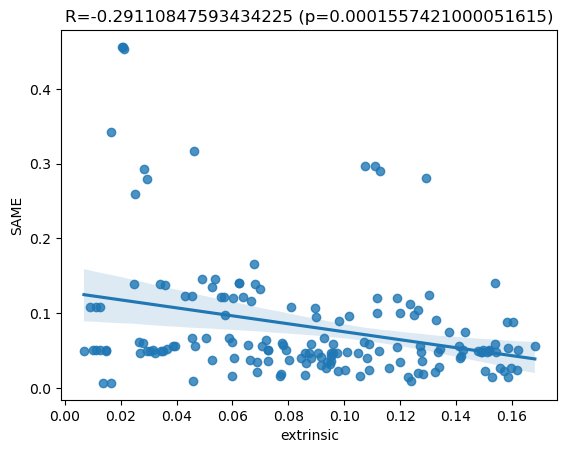


WEAT


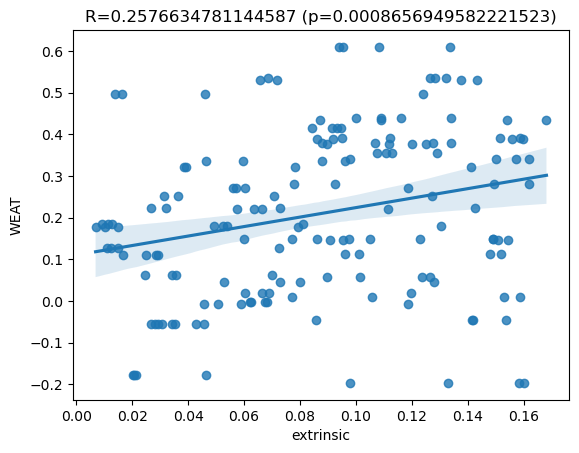


gWEAT


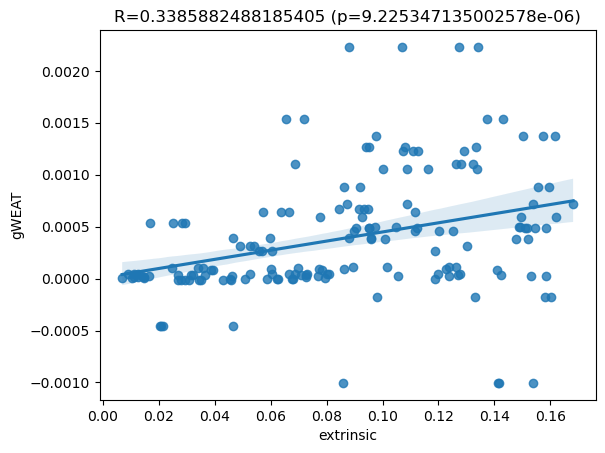


DirectBias


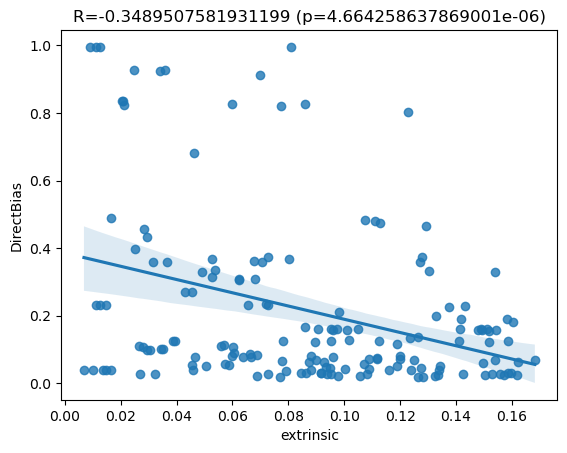


MAC


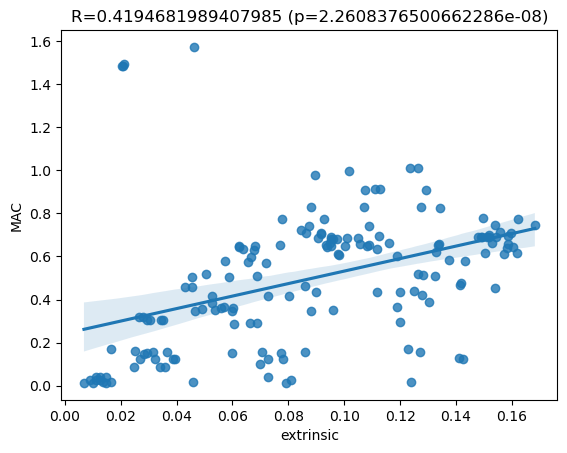


gender
SAME


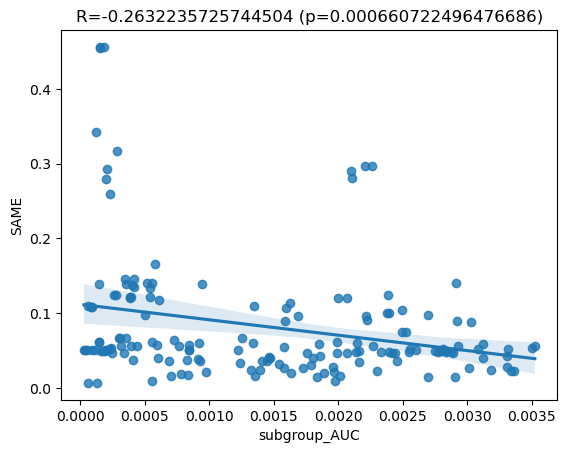


WEAT


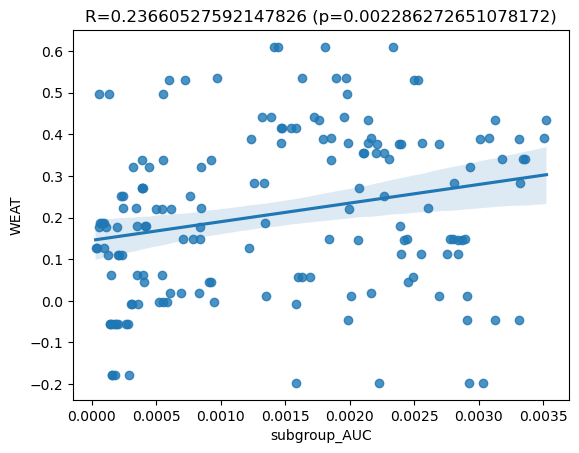


gWEAT


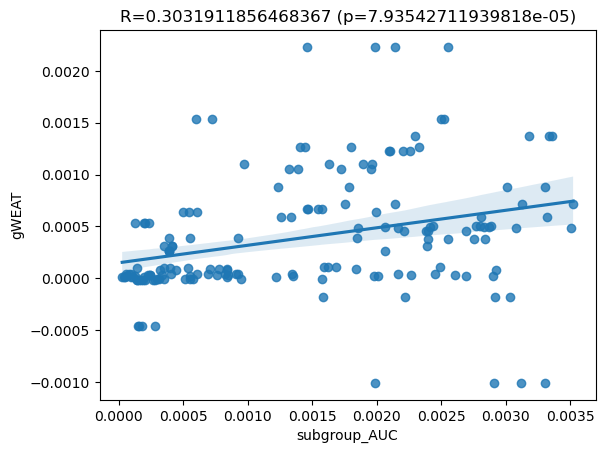


DirectBias


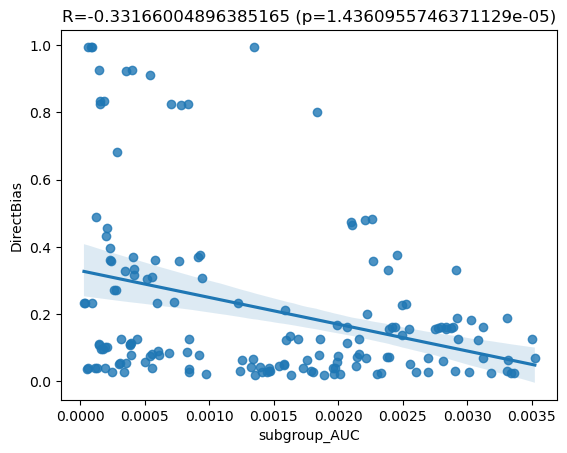


MAC


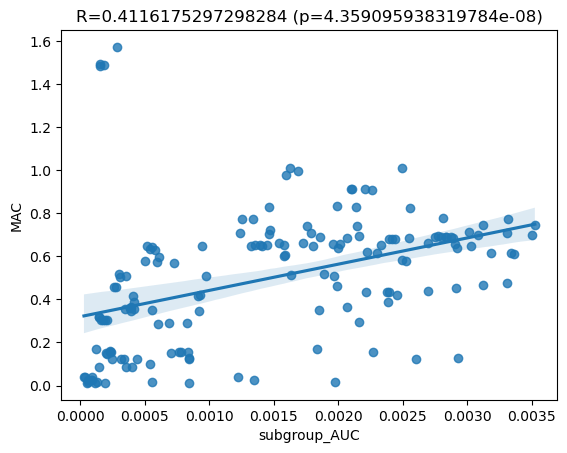


gender
SAME


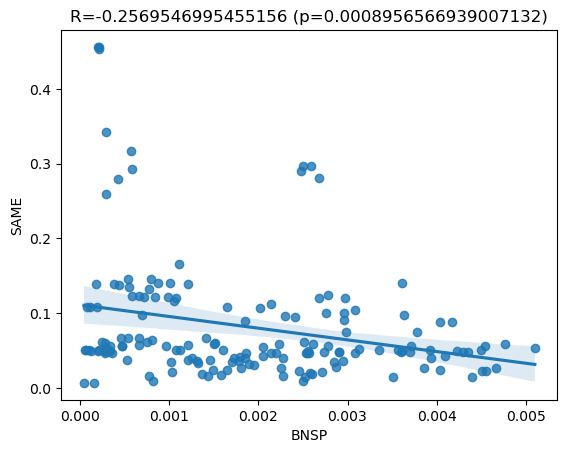


WEAT


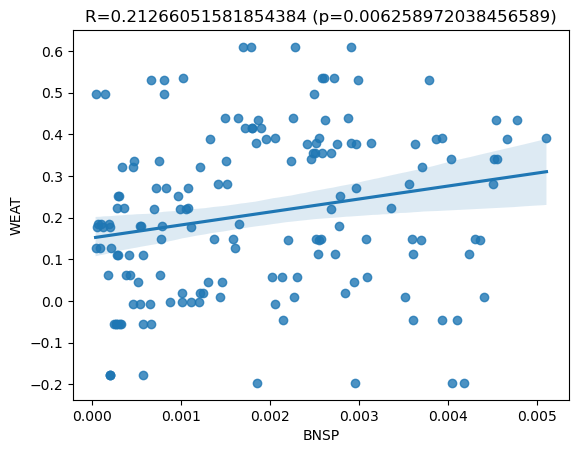


gWEAT


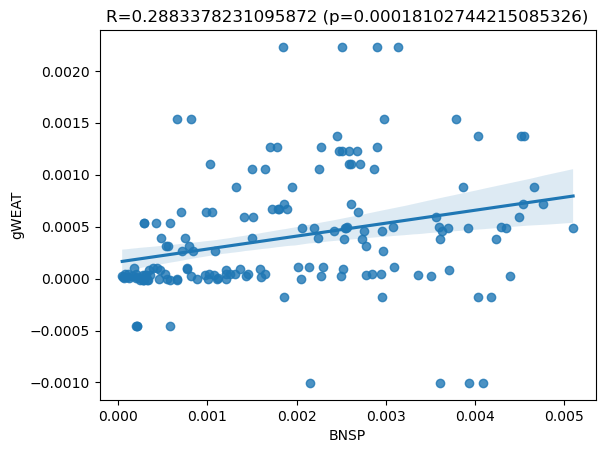


DirectBias


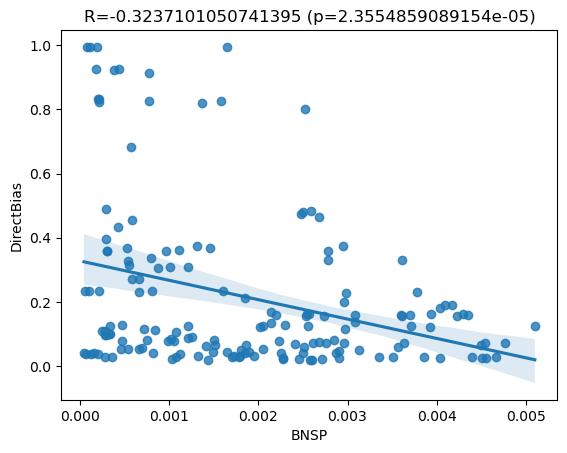


MAC


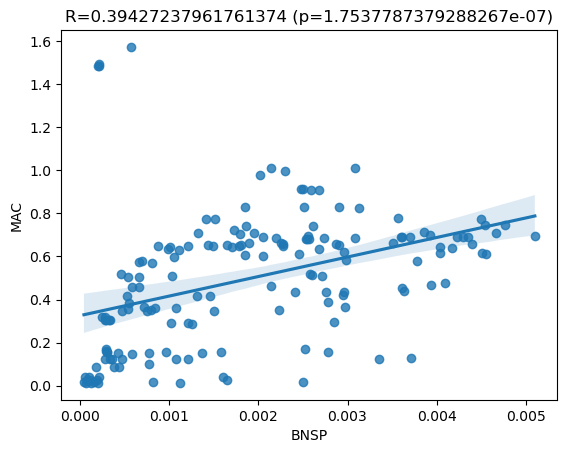


gender
SAME


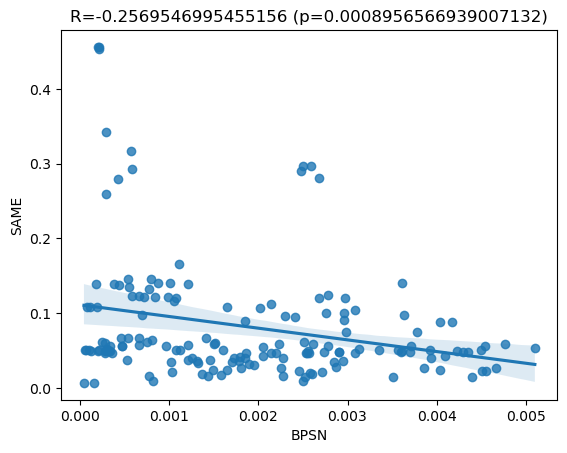


WEAT


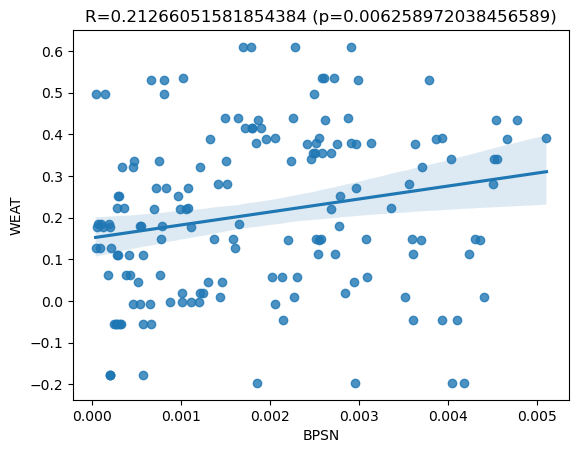


gWEAT


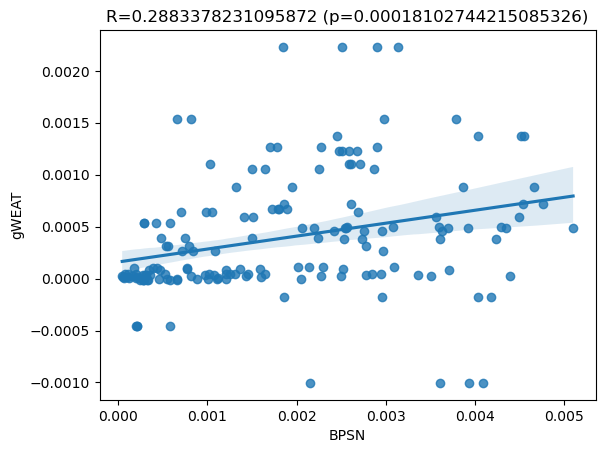


DirectBias


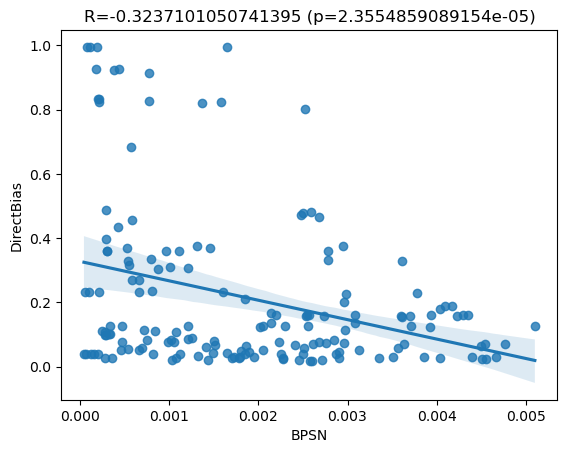


MAC


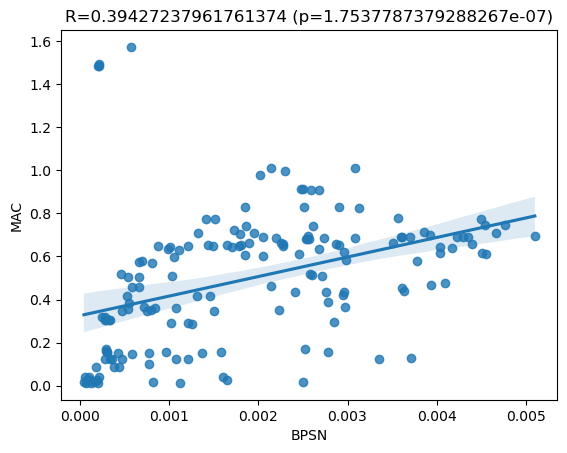

In [53]:
mean_scores = {}
for bt, res in scores_per_bias_type.items():
    mean_scores[bt] = {score: np.mean(scores_per_bias_type[bt][score], axis=1) for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']}

for comp in ['extrinsic', 'subgroup_AUC', 'BNSP', 'BPSN']:
    for bt, res in mean_scores.items():
        df = pd.DataFrame(res)
        print(bt)
        for score in score_list:
            if not score == 'extrinsic':
                print(score)
                slope, intercept, r, p, std_err = scipy.stats.linregress(df.loc[:,comp], df.loc[:,score])
                #print(r, p)
                sns.regplot(x=comp, y=score, data=df).set_title("R="+str(r)+" (p="+str(p)+")")
                plt.show()
                print()

0
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


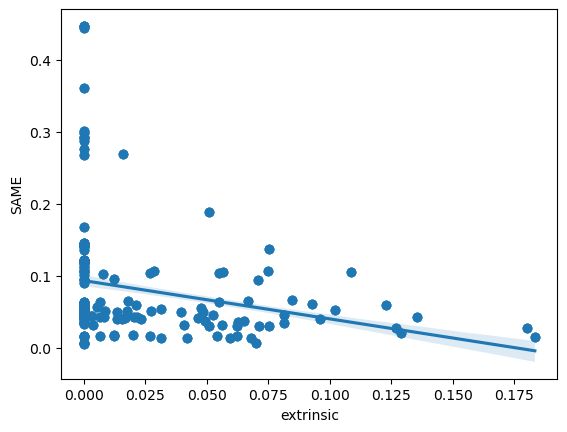

WEAT


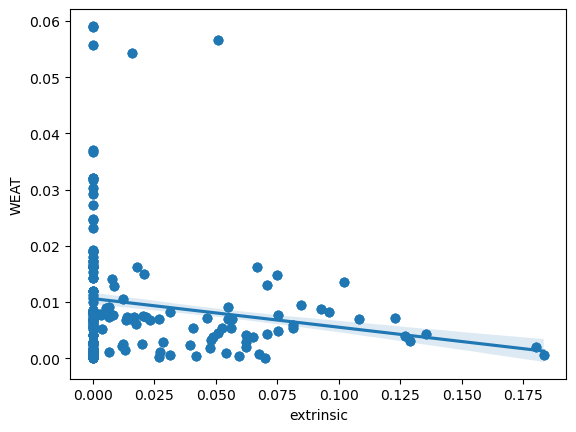

DirectBias


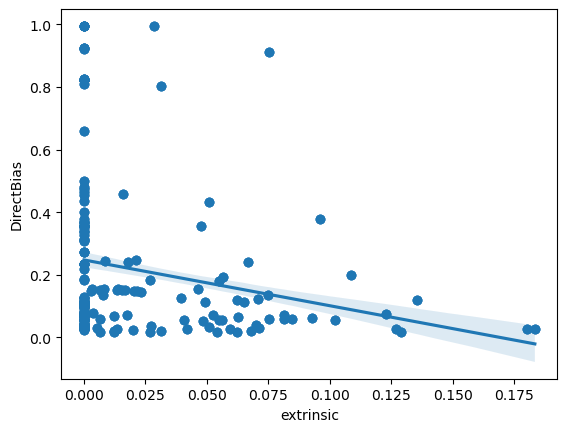

MAC


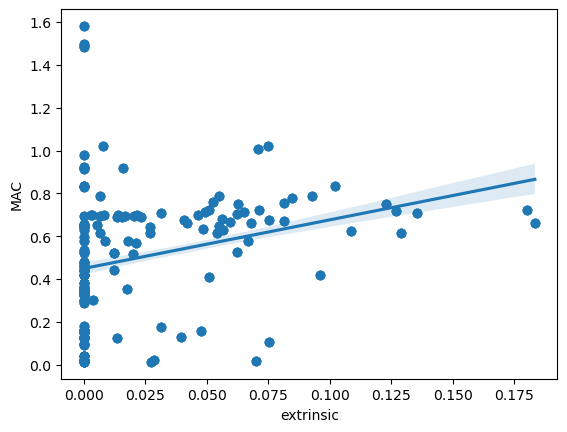



1
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


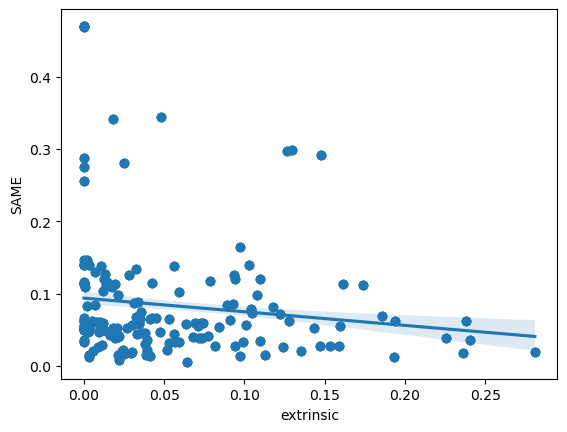

WEAT


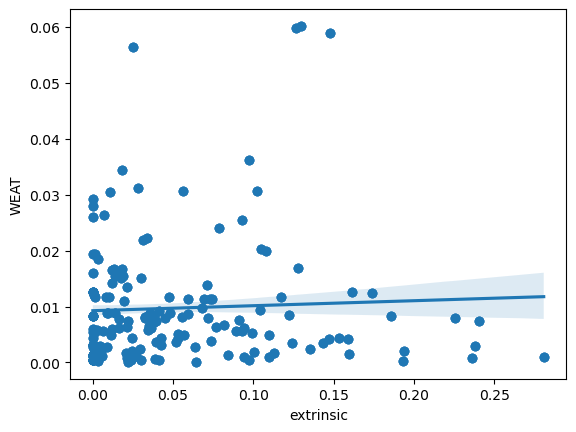

DirectBias


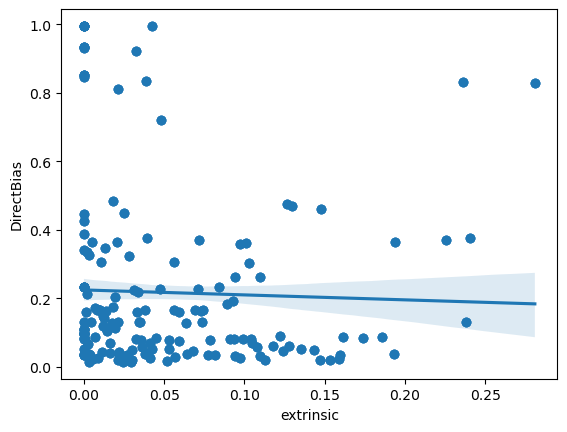

MAC


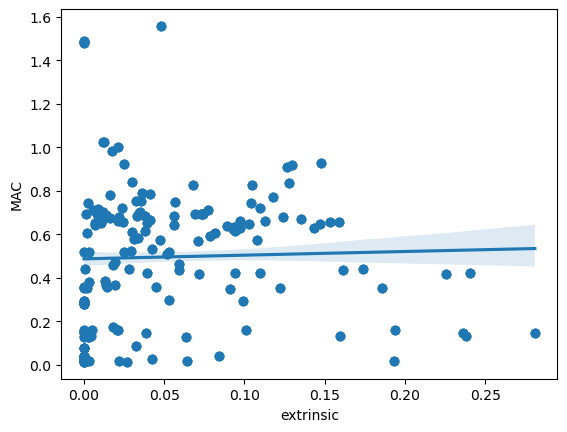



2
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


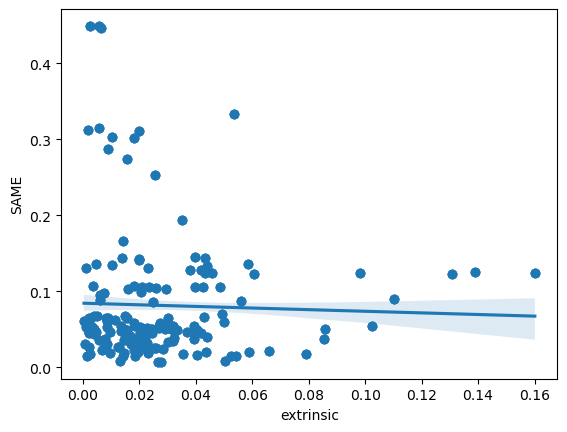

WEAT


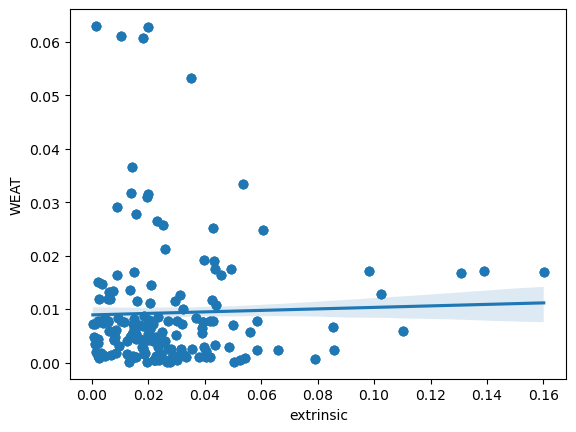

DirectBias


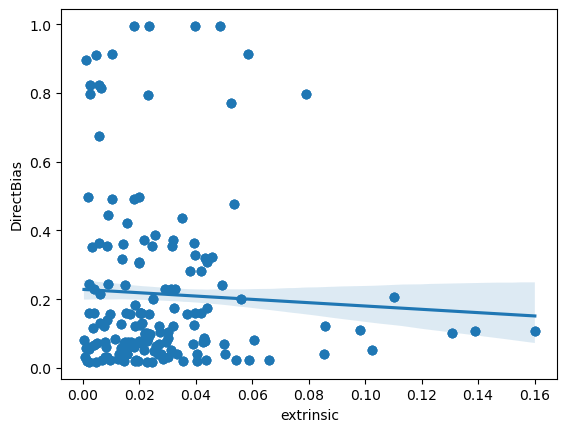

MAC


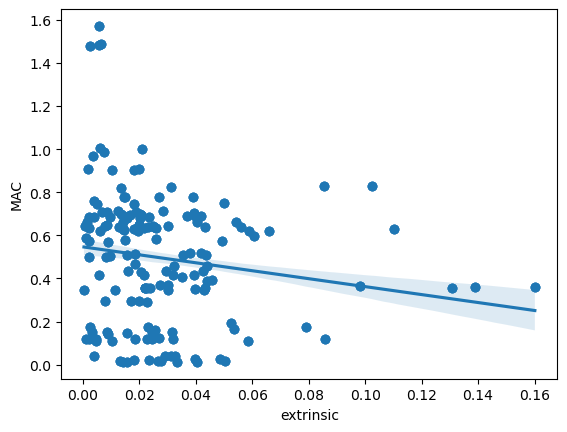



3
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


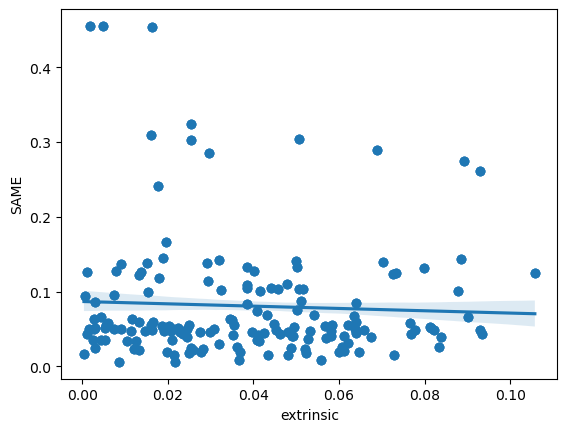

WEAT


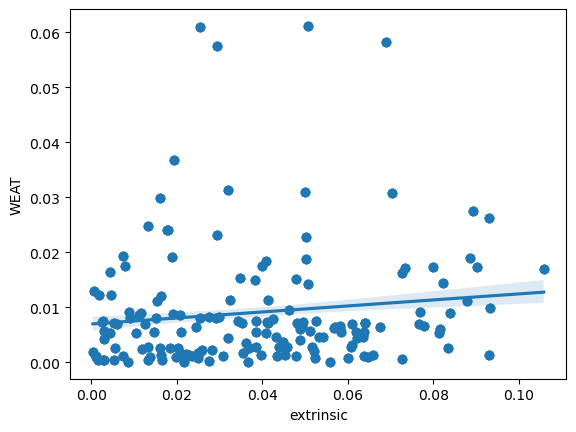

DirectBias


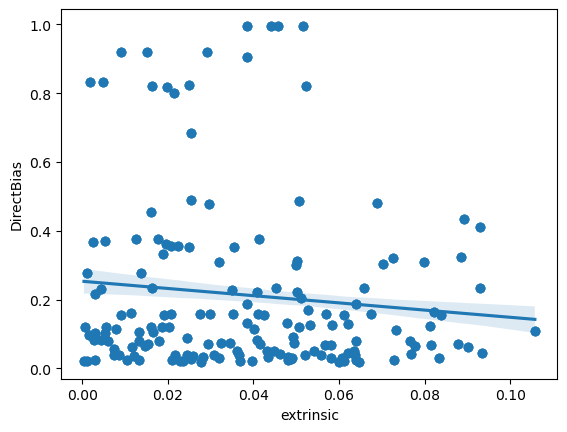

MAC


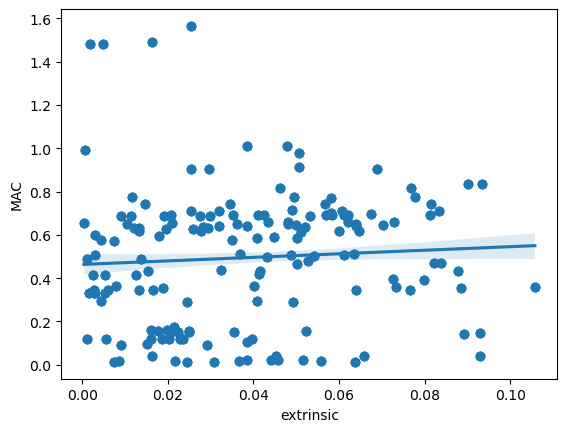



4
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


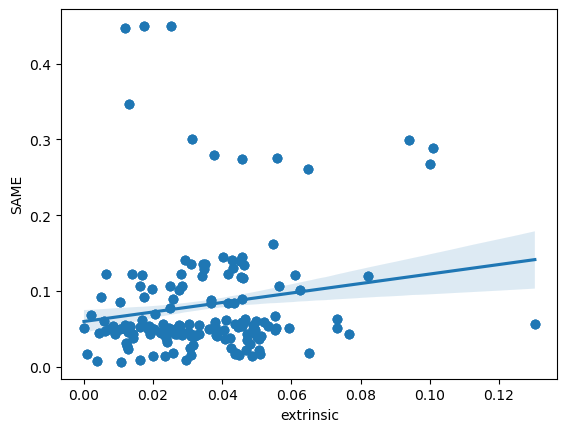

WEAT


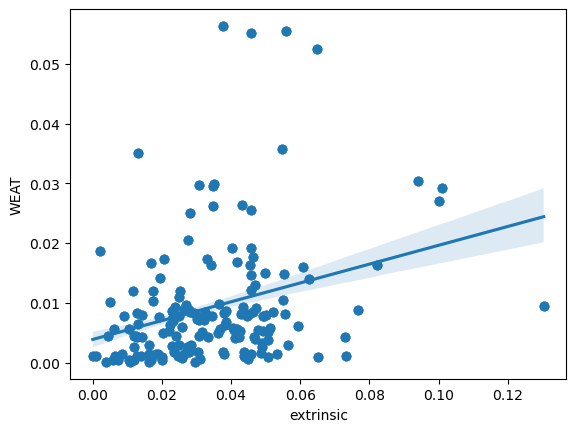

DirectBias


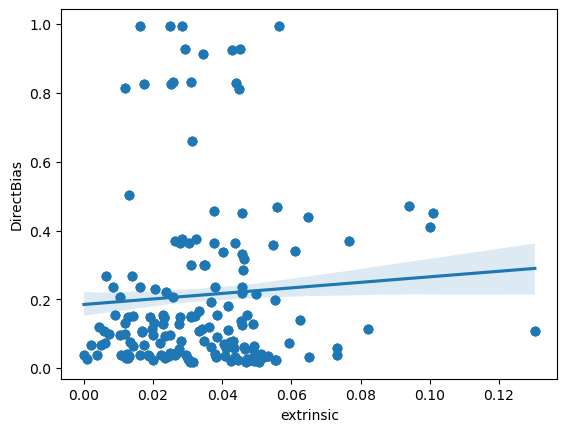

MAC


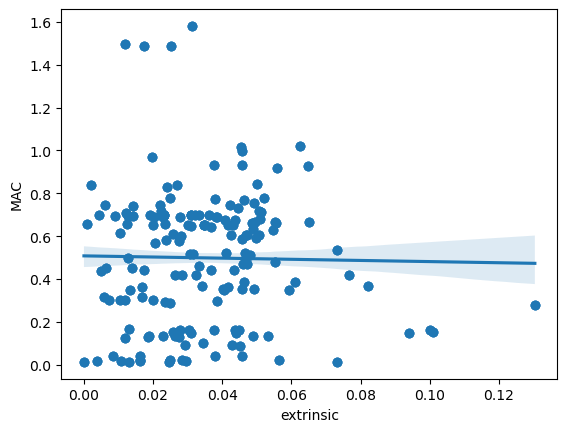



5
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


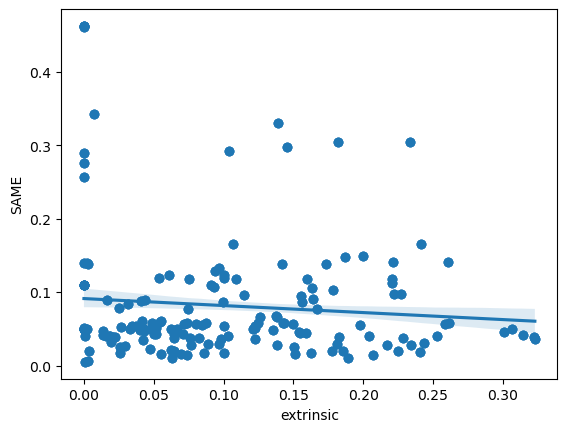

WEAT


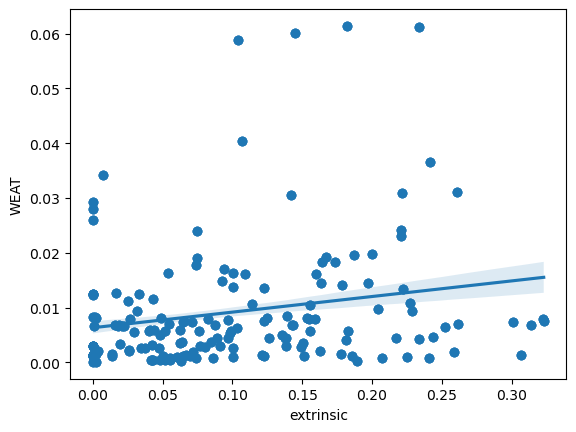

DirectBias


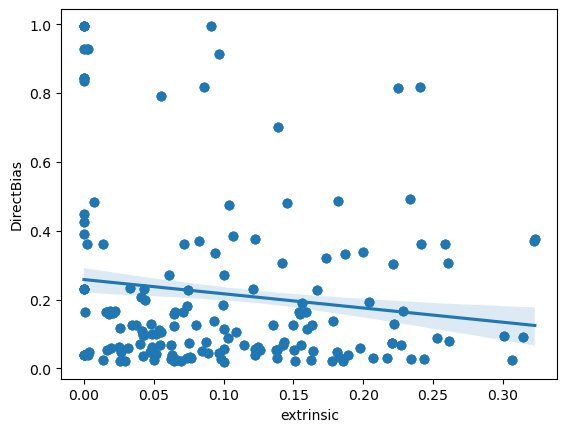

MAC


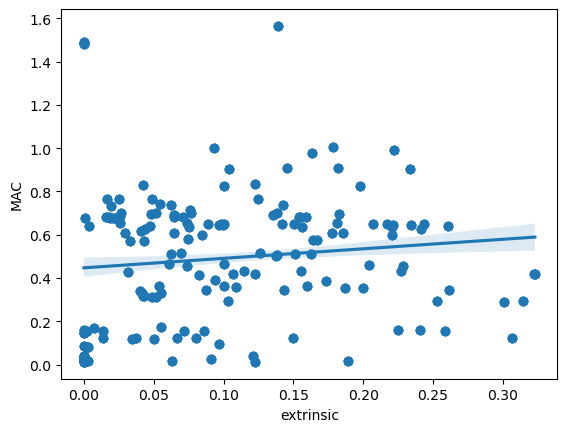



6
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


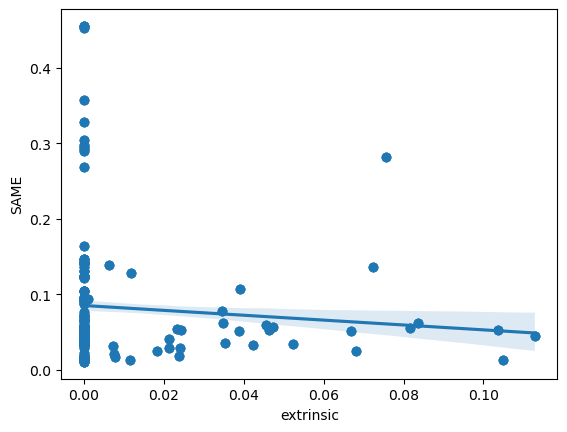

WEAT


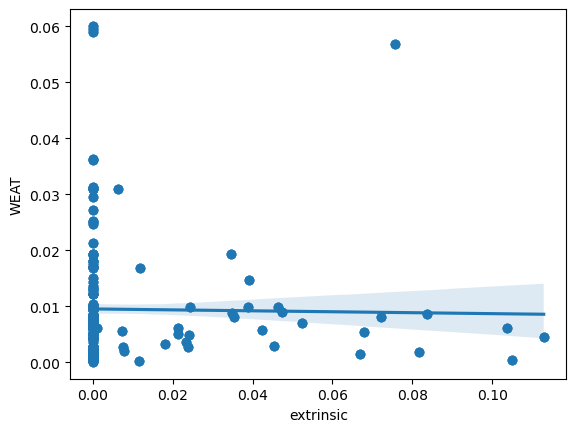

DirectBias


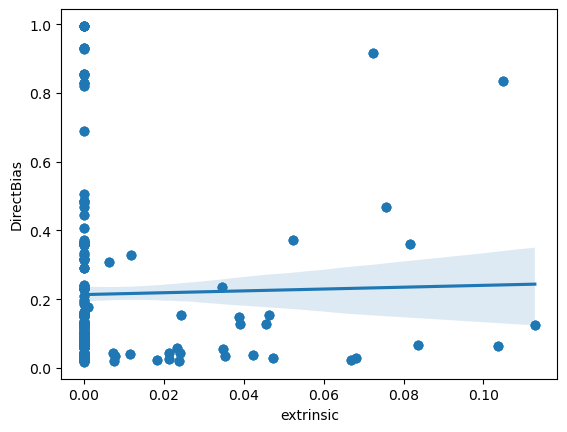

MAC


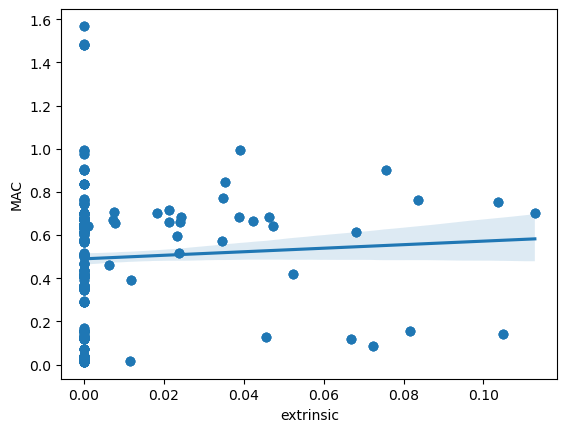



7
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


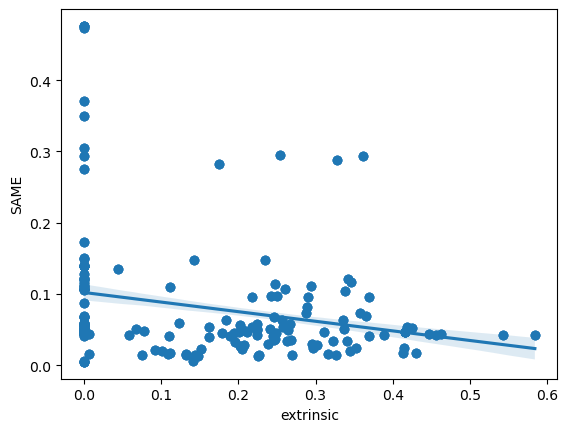

WEAT


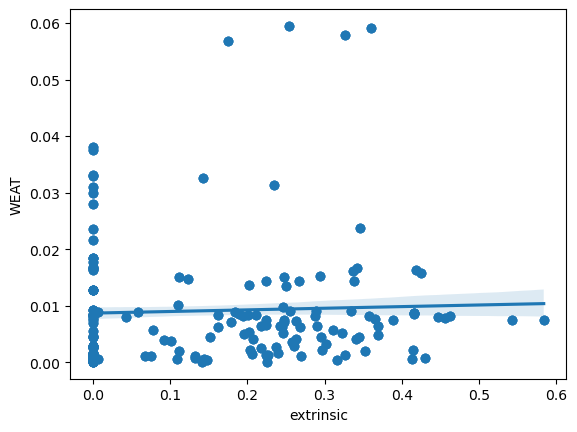

DirectBias


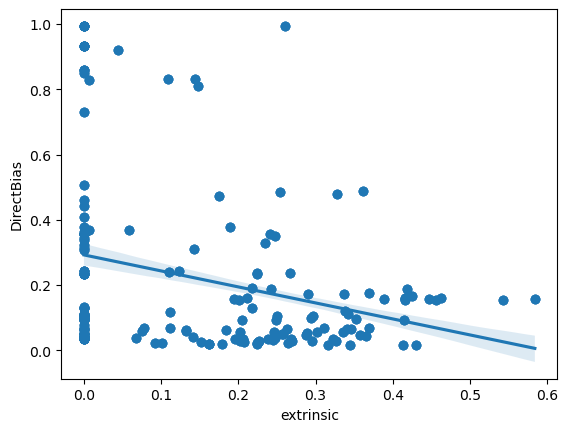

MAC


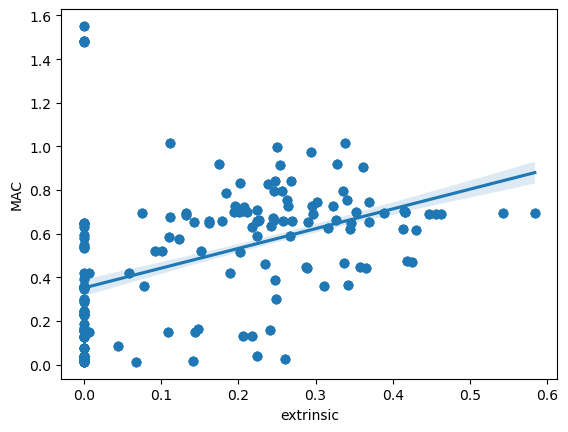



8
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


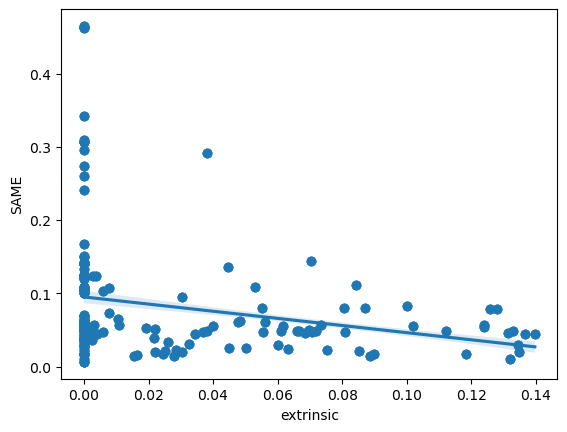

WEAT


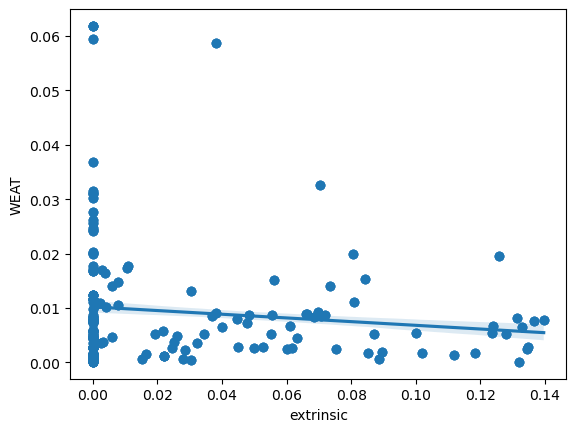

DirectBias


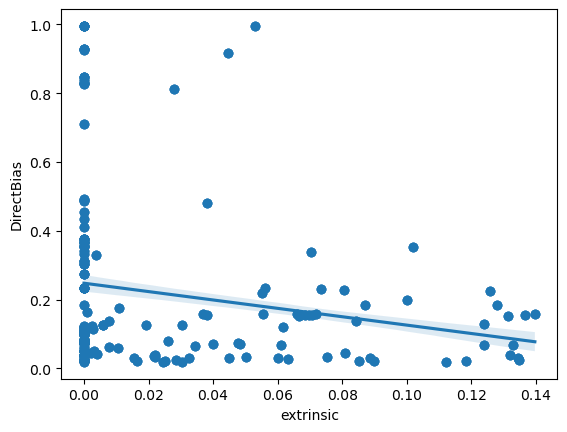

MAC


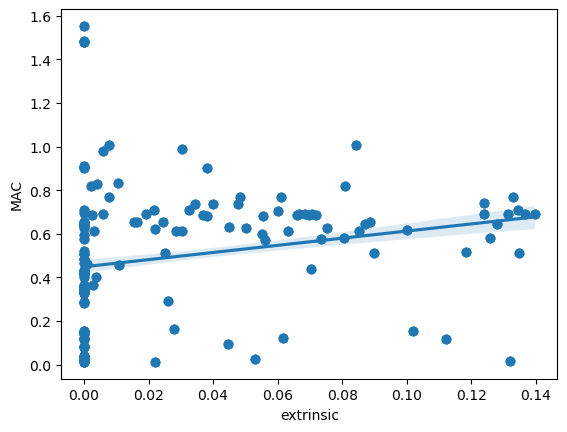



9
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


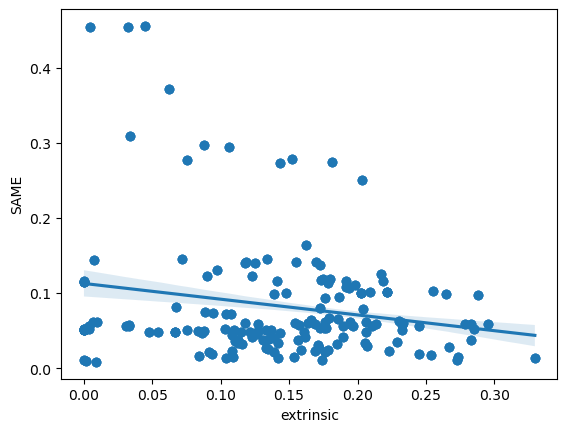

WEAT


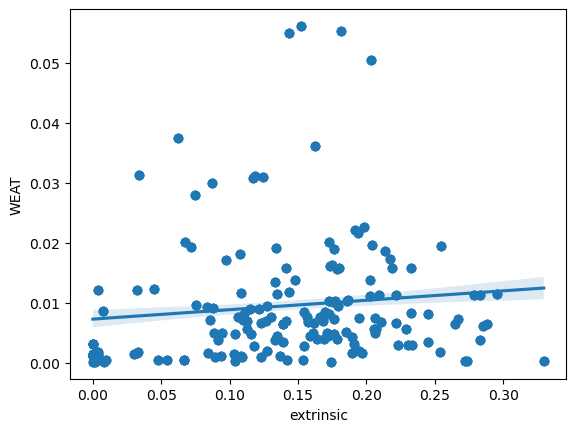

DirectBias


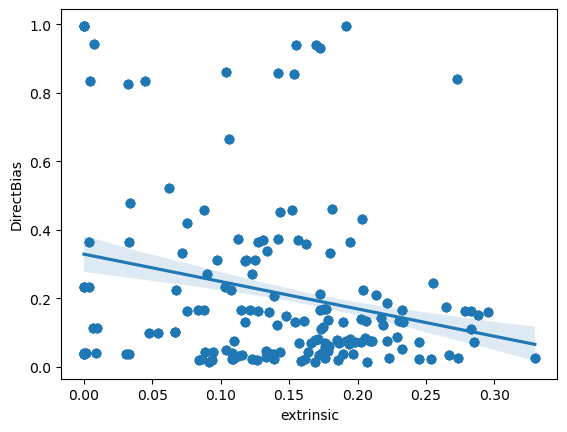

MAC


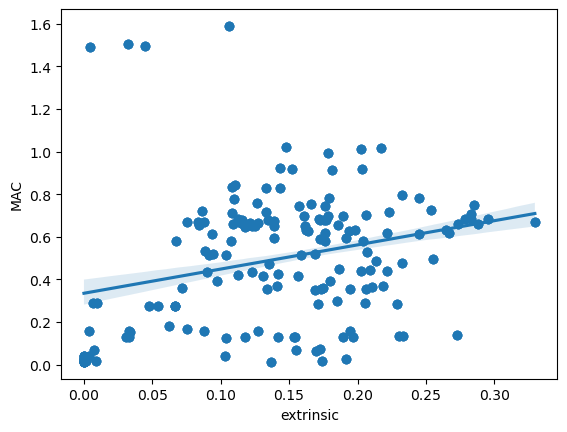



10
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


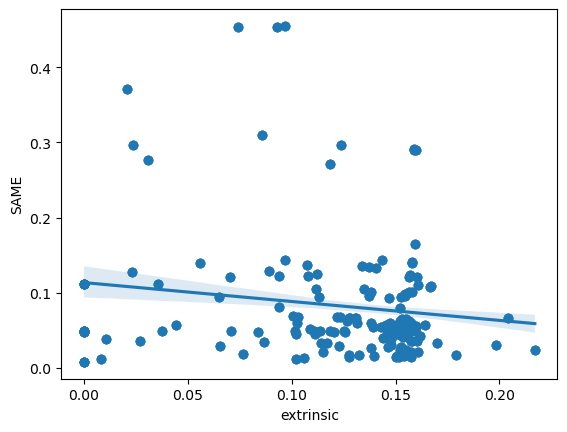

WEAT


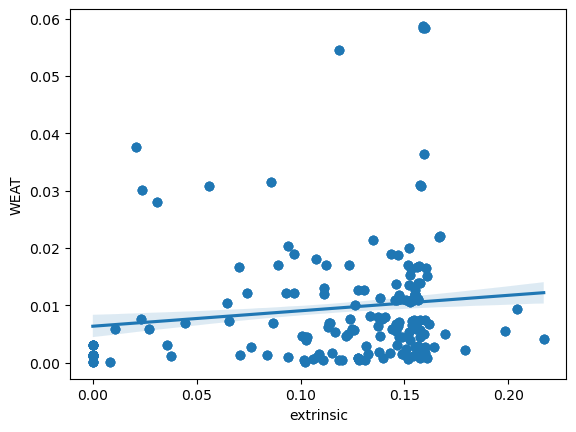

DirectBias


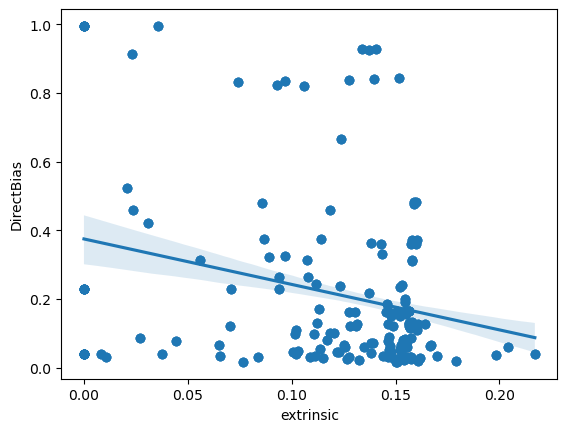

MAC


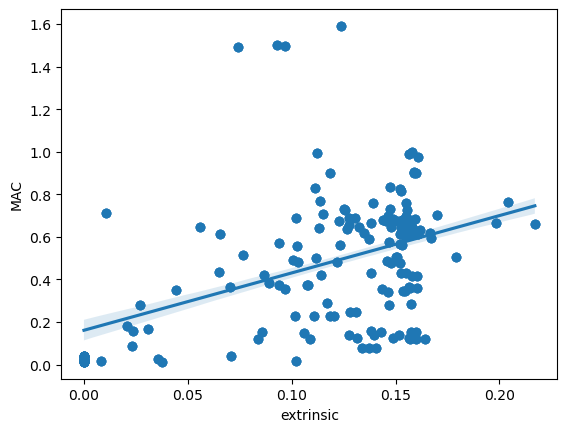



11
SAME 656
WEAT 656
DirectBias 656
MAC 656
extrinsic 656
SAME


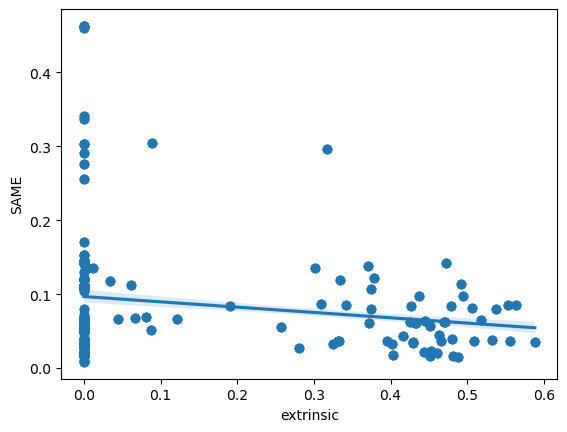

WEAT


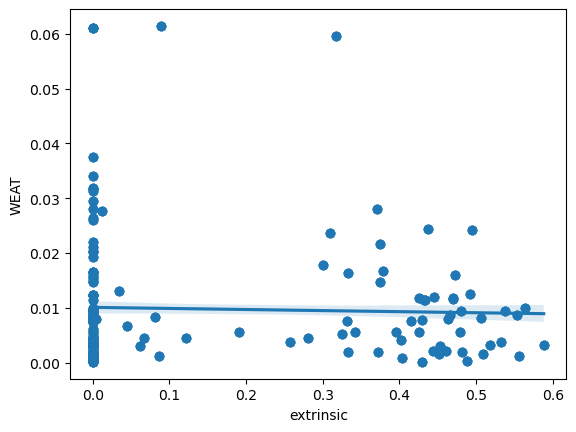

DirectBias


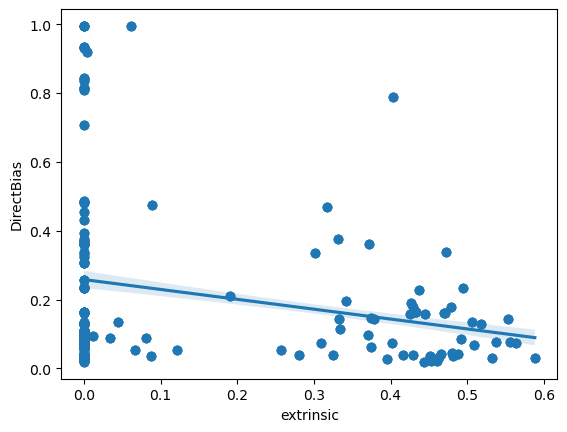

MAC


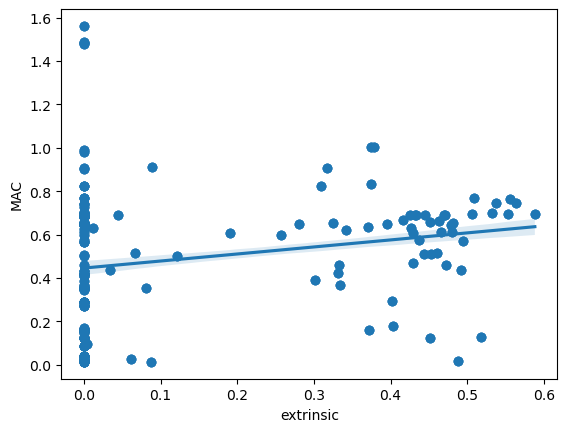

In [54]:
n_classes = class_wise_scores['SAME'][0].shape[0]
stacked_scores = {c: {} for c in range(n_classes)}
for score in score_list:
    if not score == 'gWEAT':
        for c in range(n_classes):
            stacked_scores[c][score] = np.asarray(class_wise_scores[score])[:,c]

for c in range(n_classes):
    print(c)
    for score in stacked_scores[c].keys():
        print(score, len(stacked_scores[c][score]))
    df = pd.DataFrame(stacked_scores[c])
    for score in stacked_scores[0].keys():
        if not score == 'extrinsic':
            print(score)
            sns.regplot(x="extrinsic", y=score, data=df, label="class "+str(c))        
            plt.show()
    print()
    print()

In [55]:
debias_ks = exp_config['debias_k']
embedder = exp_config['embedders']

In [56]:
results[0]['SAME']

[0.05090592571745628,
 0.05207255669383967,
 0.051832484190941976,
 0.05176282395277932,
 0.0509646873829244]

In [57]:
results[3]['SAME']

[0.06578730453350022,
 0.06452390180650329,
 0.06787264146344645,
 0.06755252319556834,
 0.06687880693505925]

In [58]:
exp_idx = 0
bias_decreased = {k: [] for k in debias_ks}
for model in embedder[:18]:
    default_scores = results[exp_idx]['extrinsic'] # one per split
    exp_idx += 1

    for k in debias_ks:
        for i, fold in enumerate(results[exp_idx]['extrinsic']):
            bias_decreased[k].append(fold < default_scores[i])
        exp_idx += 1

print("percentage of experiments with decreased extrinsic biases after hard debiasing (per k):")
for k in debias_ks:
    print(k, np.sum(bias_decreased[k])/len(bias_decreased[k]))
    
        

percentage of experiments with decreased extrinsic biases after hard debiasing (per k):
1 0.8111111111111111
3 0.9444444444444444
5 0.9888888888888889


In [59]:
decrease_agree = {score: {k: [] for k in debias_ks} for score in cosine_scores}
for score in cosine_scores:
    exp_idx = 0
    for model in embedder[:18]:
        default_scores_ex = results[exp_idx]['extrinsic'] # one per split
        default_scores_cos = results[exp_idx][score] # one per split
        exp_idx += 1

        for k in debias_ks:
            for i, fold in enumerate(results[exp_idx]['extrinsic']):
                extrinsic_decrease = fold < default_scores_ex[i]
                cosine_decrease = results[exp_idx][score][i] < default_scores_cos[i]
                decrease_agree[score][k].append(extrinsic_decrease == cosine_decrease)
            exp_idx += 1

print("how often scores agree with the extrinsic biases regarding the reduction of biases after debiasing:")
for score in cosine_scores:
    for k in debias_ks:
        print(score, k, np.sum(decrease_agree[score][k])/len(decrease_agree[score][k]))

how often scores agree with the extrinsic biases regarding the reduction of biases after debiasing:
SAME 1 0.36666666666666664
SAME 3 0.5
SAME 5 0.5444444444444444
WEAT 1 0.18888888888888888
WEAT 3 0.05555555555555555
WEAT 5 0.011111111111111112
gWEAT 1 0.18888888888888888
gWEAT 3 0.05555555555555555
gWEAT 5 0.011111111111111112
DirectBias 1 0.37777777777777777
DirectBias 3 0.36666666666666664
DirectBias 5 0.34444444444444444
MAC 1 0.7888888888888889
MAC 3 0.8888888888888888
MAC 5 0.9666666666666667
